## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

According to **eharmony's** research there are 40 million Americans using online dating websites and those users range from young to old.  If we consider Russian market of online dating there are only 10 million users by now , but demand for this kind of services is still growing, so the number is expected to reach 12 million users in the  next two years. The big players of the field such as Tinder and Badoo have huge user bases,which allow them to charge their users for premium accounts. At the same time small companies cannot afford this because of their poor user databases, so they have to come up with new ideas for monetization of their own businesses.

In order to attract advertisers to our online dating resource, we have decided to add a new feature 'Dating Ideas' to our website, where we are going to post possible places you can go with the person you met. We are willing to promote certain businesses as recommended places for a perfect first date.However, it is hard to tell which places might be interested in this kind of business offer. 

First, we want to understand the most popular places for the first dates.**(Moscow will be used in this research as the main city we target)** Second,we need to look through different boroughs in order to find certain locations with the most amount of spots that we are looking for. Finally, we can obtain the names of places those fit our model.  

## Data <a name="data"></a>

To consider the problem we can list the datas as below:

* I found Moscow Boroughs and Neighborhoods borders at http://gis-lab.info/qa/moscow-atd.html (Geographical systems of Russia). The .csv file contains all information related to Administrative Division of Moscow


* Latitudes and Longtitudes of given neighborhoods were obtained by using geopy.geocoders library


* I used Forsquare API to get the most common venues of given Borough of Moscow


* The most popular places for arranging a first date were founded from survey by Clover dating app

## Methodology <a name="methodology"></a>

The main goal of this project is to distinguish certain spots across Moscow areas that can fit our model, after obtaining the most popular venues within provided categories, we will be ready to say which places might be interested in our new advertising instruments

In first step we have collected the required data: the most popular places for a first date(restaraunt-67%, coffee shop - 23%, bar - 10%). I will use bar chart as a visualization tool to demonstrate spread of results.

Second step in our analysis is getting boroughs and neighborhoods of Moscow and connecting them with consisting latitudes and longitudes. In order to achieve this we will use geopy.geocoders library.

In third and final step we will focus on most promising areas and within those create clusters of locations that meet some basic requirements established in previous parts: we will take into consideration locations with big amounts of venues that match one of our three categories, and we want to find certain patterns of brands repeating in different locations . We will present map of all such locattions but also create clusters (using k-means clustering) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for applying our ideas. Finally, we will create a list of top 10 venues, those we will target first.

## Retrieving dating data


As it was mentioned, we gather the information based on Clover's research. So we transfered all the information into an excel file. So first let's import all required libraries, and then import excel file and add it into a pandas dataframe.

In [1]:
 import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
import json

import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import folium
from geopy.geocoders import Nominatim
import xlrd
print('Libraries imported') 

Libraries imported


In [2]:
dating = 'C:\\Users\\Администратор\\Desktop\\Clover.xlsx'
dating_data = pd.read_excel(dating)
dating_data

,Venue Name,Category
0,Starbucks,Coffee Shop
1,Chipotle Mexican Grile,Restaurant
2,Panera Bread,Coffee Shop
3,The Cheesecake Factory,Restaurant
4,Texas Road House,Restaurant
5,Buffalo Wild Wings,Restaurant
6,Olive Garden,Restaurant
7,Chili's Grill&Bar,Bar
8,In-N-Out Burger,Restaurant
9,Applebee's,Restaurant


As we can understand from this dataframe there are three main categories: Restaraunt, Bar, Coffee Shop. Let's create a new dataframe using .value_counts() so we can see the spread of these values.


In [3]:
dating_categories = pd.DataFrame(dating_data.Category.value_counts().reset_index().values, columns=["Category", "Amount"])
dating_categories.head()

,Category,Amount
0,Restaurant,20
1,Coffee Shop,7
2,Bar,3


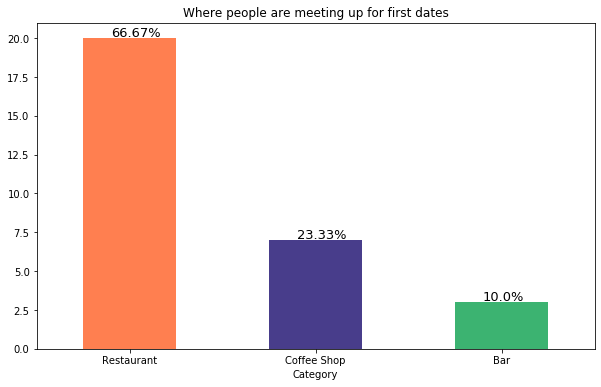

In [4]:
ax = dating_categories.plot.bar(x = 'Category',y = 'Amount',figsize=(10,6),color=['coral','darkslateblue','mediumseagreen'],legend = '',rot= 0)
plt.title('Where people are meeting up for first dates')



totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.15, i.get_height()+.1, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=13,
                color='black')

plt.show()

Here we can see the most popular first date places. Although bar is not the most popular venue, we are still going to use it in our research

## Download and Explore Dataset

First, we want to get all the information related to Moscow Boroughs and Neighborhoods, but the problem we face is that the file is archieved in .zip file, so we will need to import a few additional libraries - urlib.request and zipfile.

In [5]:
import urllib.request
url = 'http://gis-lab.info/data/mos-adm/mo-csv.zip'
file_name = 'mo-csv.zip'
urllib.request.urlretrieve(url, file_name)

('mo-csv.zip', <http.client.HTTPMessage at 0x1982eda0>)

In [6]:
from zipfile import ZipFile

In [7]:
with ZipFile('mo-csv.zip', 'r') as zipObj:
   # Get a list of all archived file names from the zip
   listOfFileNames = zipObj.namelist()
   # Iterate over the file names
   for fileName in listOfFileNames:
       # Check filename endswith csv
       if fileName.endswith('.csv'):
           # Extract a single file from zip
           neighborhoods = zipObj.extract(fileName, 'temp_csv')


Our .zip file that we downloaded contains .csv, which now we can simply open by using pd.read_csv method

In [8]:
neighborhoods = pd.read_csv(neighborhoods)
neighborhoods.head()

,WKT,NAME,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO
0,"MULTIPOLYGON (((36.8031012 55.4408329,36.80319...",Киевский,45298555,45945000,Троицкий,45298000,Троицкий,Поселение
1,"POLYGON ((37.4276499 55.7482092,37.4284863 55....",Филёвский Парк,45268595,45328000,Западный,45268000,ЗАО,Муниципальный округ
2,"POLYGON ((36.8035692 55.4516224,36.8045117 55....",Новофёдоровское,45298567,45954000,Троицкий,45298000,Троицкий,Поселение
3,"POLYGON ((36.9372397 55.2413907,36.9372604 55....",Роговское,45298575,45956000,Троицкий,45298000,Троицкий,Поселение
4,"POLYGON ((37.4395575 55.6273129,37.4401803 55....","""Мосрентген""",45297568,45953000,Новомосковский,45297000,Новомосковский,Поселение



Let's clean our dataframe and get rid of the columns we don't need


In [9]:
neighborhoods = neighborhoods.drop(neighborhoods.columns[[0,2,3,5,6,7]], axis=1)
neighborhoods.head()

,NAME,NAME_AO
0,Киевский,Троицкий
1,Филёвский Парк,Западный
2,Новофёдоровское,Троицкий
3,Роговское,Троицкий
4,"""Мосрентген""",Новомосковский



We got names of boroughs and neighborhoods,but we still don't have latitudes and longitudes values that match our locations. So let's use geopy.geocoders library in order to obtain those values.


In [10]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = 'foursquare_agent')

Latitude = []
Longitude = []
loc_address = []
for address in neighborhoods.NAME:
    try:
        inputAddress = address
        location = geolocator.geocode(inputAddress, timeout=15)
        Latitude.append((location.latitude))
        Longitude.append((location.longitude))
        loc_address.append(inputAddress)
    except Exception as e:
        print('Error, skipping address...', e)


df_geocodes = pd.DataFrame({'Latitude':Latitude,'Longitude':Longitude,'NAME':loc_address})


Let's take a look at the output 


In [11]:
df_geocodes

,Latitude,Longitude,NAME
0,50.785300,136.285748,Киевский
1,55.747055,37.492181,Филёвский Парк
2,53.418537,55.741158,Новофёдоровское
3,48.419365,34.483074,Роговское
4,55.621703,37.472727,"""Мосрентген"""
5,64.022572,41.714897,Вороновское
6,55.402712,37.152744,Михайлово-Ярцевское
7,55.581915,37.178949,Марушкинское
8,60.357807,29.735750,Первомайское
9,56.009535,37.197378,Матушкино


Next we need to merge two dataframes into one final dataframe that we will use for analysis.

In [12]:
moscow_data = pd.merge(neighborhoods, df_geocodes, how='inner', on=['NAME', 'NAME'])


And for the last step in this section we should drop a few rows because their latitude&longitude values don't relate to Moscow 
coordinates


In [13]:
moscow_data = moscow_data.drop([0,2,3,5,8,21,23,30,37,39,51,53,54,60,67,69,81,90,94,109,113,115,120,121,126,134,144])
moscow_data.head()

,NAME,NAME_AO,Latitude,Longitude
1,Филёвский Парк,Западный,55.747055,37.492181
4,"""Мосрентген""",Новомосковский,55.621703,37.472727
6,Михайлово-Ярцевское,Троицкий,55.402712,37.152744
7,Марушкинское,Новомосковский,55.581915,37.178949
9,Матушкино,Зеленоградский,56.009535,37.197378


## Analysis <a name="analysis"></a>

In order to define an instance of the geocoder,we need to define a user_agent. We will name our agent moscow_explorer

In [14]:
address = 'Moscow,Russian Federation'
geolocator = Nominatim(timeout=3,user_agent = 'moscow_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Moscow are {},{}.'.format(latitude,longitude))

The geographical coordinate of Moscow are 55.7504461,37.6174943.



Let's use folium library to visualize geographic details of Moscow and its boroughs.

In [15]:
map_moscow = folium.Map(location = [latitude,longitude],zoom_start = 10)


Now we need to add markers on our map, so we can see clearly all boroughs and neighborhoods of Moscow. After that we can visualize the map.


In [16]:
for lat,lng,borough,neighborhood in zip(moscow_data['Latitude'],moscow_data['Longitude'],moscow_data['NAME_AO'],moscow_data['NAME']):
    label = '{},{}'.format(neighborhood,borough)
    label = folium.Popup(label,parse_html = True)
    folium.CircleMarker([lat,lng],radius = 5,popup = label,color = 'blue',fill = True, fill_color = '#3186cc',fill_opacity = 0.7,parse_html = False).add_to(map_moscow)

In [17]:
map_moscow


Next we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them


In [18]:
CLIENT_ID = 'SBA3ULRLW0H401RUKMBKKT3PTDKC1IUQ2RRROCP2KG5MY0EI'
CLIENT_SECRET = 'GRSZCACKBADCARVKFKL3UGYX0TQL42KVATSZ4C5RSCCIOTAW'
VERSION = '20180605'


Since we are going to cover the whole territory of Moscow we cannot afford looking up huge amounts of venues for each neighborhood. So let's set up some limits for number of venues and radius.


In [19]:
LIMIT = 10
radius = 500


Let's create a function to find top 10 venues for each of our neighborhoods in radius of 1000 meters


In [20]:
def getNearbyVenues(names,latitudes,longitudes,radius = 1000):
    
    venues_list = []
    for name,lat,lng in zip(names,latitudes,longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.\
        format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(name,lat,lng,v['venue']['name'],v['venue']['location']['lat'],v['venue']['location']['lng'],v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        
    nearby_venues.columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue',\
                                 'Venue Latitude','Venue Longitude','Venue Category']
        
    return(nearby_venues)


Now let's write the code to run the above function on each neighborhood and create a new dataframe called downtown_venues


In [22]:
moscow_venues = getNearbyVenues(names= moscow_data['NAME'],\
                                  latitudes=moscow_data['Latitude'],longitudes=moscow_data['Longitude'])



Let's check the size of resulting dataframe


In [23]:
print(moscow_venues.shape)
moscow_venues.head(50)


(1088, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Филёвский Парк,55.747055,37.492181,ПКиО «Фили»,55.747953,37.484884,Park
1,Филёвский Парк,55.747055,37.492181,Главная аллея,55.750473,37.491314,Pedestrian Plaza
2,Филёвский Парк,55.747055,37.492181,Дворец водного спорта «Фили»,55.748703,37.499646,Pool
3,Филёвский Парк,55.747055,37.492181,Up-House.RU,55.744807,37.495704,Electronics Store
4,Филёвский Парк,55.747055,37.492181,РЕПАСТ,55.746624,37.492945,Café
5,Филёвский Парк,55.747055,37.492181,HL | Holy Land,55.749521,37.502167,Cosmetics Shop
6,Филёвский Парк,55.747055,37.492181,НикОль,55.749222,37.501394,Cosmetics Shop
7,Филёвский Парк,55.747055,37.492181,AJ.ru,55.743721,37.505963,Electronics Store
8,Филёвский Парк,55.747055,37.492181,Хип - Хоп точка,55.742453,37.503039,Music Store
9,Филёвский Парк,55.747055,37.492181,Рыбная мануфактура №1,55.738497,37.491162,Fish Market


Let's check how many venues were returned for each neighborhood

In [24]:
moscow_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"""Мосрентген""",10,10,10,10,10,10
Академический,3,3,3,3,3,3
Алексеевский,10,10,10,10,10,10
Алтуфьевский,10,10,10,10,10,10
Арбат,10,10,10,10,10,10
Аэропорт,10,10,10,10,10,10
Бабушкинский,10,10,10,10,10,10
Басманный,10,10,10,10,10,10
Беговой,10,10,10,10,10,10



Now let's find out how many unique categories can be extracted from all the returned venues


In [25]:
print('There are {} uniques categories.'.format(len(moscow_venues['Venue Category'].unique())))

There are 209 uniques categories.



Let's analyze each neighborhood


In [26]:
moscow_onehot = pd.get_dummies(moscow_venues[['Venue Category']],prefix="",prefix_sep="")

moscow_onehot['Neighborhood'] = moscow_venues['Neighborhood']

cols = list(moscow_onehot)
cols.insert(0, cols.pop(cols.index('Neighborhood')))

moscow_onehot = moscow_onehot.loc[:, cols]
moscow_onehot.shape
moscow_onehot.head(100)

,Neighborhood,Afghan Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,Baby Store,Bakery,Bar,Basketball Court,Bath House,Beach,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Trail,Bistro,Blini House,Board Shop,Bookstore,Botanical Garden,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Bus Station,Bus Stop,Butcher,Café,Candy Store,Car Wash,Castle,Caucasian Restaurant,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Forest,Fountain,French Restaurant,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Hookah Bar,Hotel,Hotel Bar,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Kids Store,Korean Restaurant,Lake,Lingerie Store,Liquor Store,Martial Arts Dojo,Massage Studio,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Notary,Office,Other Great Outdoors,Other Repair Shop,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Racetrack,Recording Studio,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Road,Rugby Stadium,Salon / Barbershop,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tailor Shop,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Track,Trail,Train,Train Station,Tram Station,Travel Agency,Tree,Tunnel,Ukrainian Restaurant,Vape Store,Veterinarian,Vietnamese Restaurant,Waterfall,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Филёвский Парк,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Филёвский Парк,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Филёвский Парк,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The table we got is still hardly readable so let's group rows by neighborhood and by taking the mean of the frequency of occurence of each category. After that let's confirm the new size


In [27]:
moscow_grouped = moscow_onehot.groupby('Neighborhood').mean().reset_index()
moscow_grouped.shape

(115, 210)


Now let's take a look at the dataframe we got


In [28]:
moscow_grouped

,Neighborhood,Afghan Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,Baby Store,Bakery,Bar,Basketball Court,Bath House,Beach,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Trail,Bistro,Blini House,Board Shop,Bookstore,Botanical Garden,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Bus Station,Bus Stop,Butcher,Café,Candy Store,Car Wash,Castle,Caucasian Restaurant,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Forest,Fountain,French Restaurant,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hockey Rink,Hookah Bar,Hotel,Hotel Bar,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Kids Store,Korean Restaurant,Lake,Lingerie Store,Liquor Store,Martial Arts Dojo,Massage Studio,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Notary,Office,Other Great Outdoors,Other Repair Shop,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Racetrack,Recording Studio,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Road,Rugby Stadium,Salon / Barbershop,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tailor Shop,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Track,Trail,Train,Train Station,Tram Station,Travel Agency,Tree,Tunnel,Ukrainian Restaurant,Vape Store,Veterinarian,Vietnamese Restaurant,Waterfall,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"""Мосрентген""",0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.100000,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.1,0.0,0.0,0.000000,0.0,0.0,0.1,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.2,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.100000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,Академический,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.333333,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,


Let's print each neighborhood along with the top 3 most common venues


In [29]:
num_top_venues = 3

for hood in moscow_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = moscow_grouped[moscow_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----"Мосрентген"----
                  venue  freq
0                  Park   0.2
1  Gym / Fitness Center   0.2
2  Caucasian Restaurant   0.1


----Академический----
        venue  freq
0  Bath House  0.33
1       Beach  0.33
2    Mountain  0.33


----Алексеевский----
               venue  freq
0               Park   0.2
1        Snack Place   0.1
2  Convenience Store   0.1


----Алтуфьевский----
         venue  freq
0  Supermarket   0.2
1  Gas Station   0.1
2     Gym Pool   0.1


----Арбат----
         venue  freq
0  Coffee Shop   0.2
1       Museum   0.2
2      Theater   0.1


----Аэропорт----
               venue  freq
0        Coffee Shop   0.3
1      Deli / Bodega   0.1
2  Health Food Store   0.1


----Бабушкинский----
                  venue  freq
0                   Gym   0.2
1   Japanese Restaurant   0.1
2  Fast Food Restaurant   0.1


----Басманный----
              venue  freq
0  Recording Studio   0.1
1        Public Art   0.1
2         Gun Range   0.1


----Беговой----
     

                   venue  freq
0            Supermarket   0.2
1              Irish Pub   0.1
2  Performing Arts Venue   0.1


----Останкинский----
            venue  freq
0            Park   0.2
1  Scenic Lookout   0.2
2   Garden Center   0.1


----Очаково-Матвеевское----
           venue  freq
0         Notary  0.11
1  Big Box Store  0.11
2       Pharmacy  0.11


----Печатники----
                  venue  freq
0                  Park   0.2
1  Gym / Fitness Center   0.2
2           Pizza Place   0.2


----Покровское-Стрешнево----
              venue  freq
0        Beer Store   0.1
1        Hobby Shop   0.1
2  Sushi Restaurant   0.1


----Преображенское----
               venue  freq
0       Dance Studio   0.2
1  Health Food Store   0.1
2         Steakhouse   0.1


----Пресненский----
          venue  freq
0  Dance Studio   0.2
1        Tunnel   0.1
2      Beer Bar   0.1


----Проспект Вернадского----
                     venue  freq
0  Health & Beauty Service   0.1
1        Health Food

We obtained top 3 venues for all neighborhoods,but it's to complex, so we need to simplify it.For our further analysis let's put all of data into pandas dataframe. We want to see the most common venues of each neighborhood more clear, so let's write a function to sort the venues in descending order.

In [126]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [215]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = moscow_grouped['Neighborhood']

for ind in np.arange(moscow_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(moscow_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,"""Мосрентген""",Park,Gym / Fitness Center,Caucasian Restaurant
1,Академический,Mountain,Beach,Bath House
2,Алексеевский,Park,Snack Place,Pet Store
3,Алтуфьевский,Supermarket,Grocery Store,Gym Pool
4,Арбат,Coffee Shop,Museum,Theater


We need to research three common venues for a first date:Restataunt, Coffee Shop, Bar. So let's look through all of three common venues for each of our places.
As we remember the place we are most interested in is restaraunt, so let's search for the names of areas that have restaraunt as the most popular venue. Also Foursquare has plenty different types of restaraunts, so in order to make it easier, we will look which string contains combination of letters 'ant' .



In [216]:
popular_venues_1 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains('ant')]

popular_venues_2 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['2nd Most Common Venue'].str.contains('ant')]

popular_venues_3 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['3rd Most Common Venue'].str.contains('ant')]


We will look at the final dataframe later after we merge and clean it, so now let's do the same thing with coffee shop.


In [217]:
popular_venues_4 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains('Coffee Shop')]

popular_venues_5 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['2nd Most Common Venue'].str.contains('Coffee Shop')]

popular_venues_6 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['3rd Most Common Venue'].str.contains('Coffee Shop')]


And finally let's find out about third place we interested in 'Bar'


In [218]:
popular_venues_7 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains('Bar')]

popular_venues_8 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['2nd Most Common Venue'].str.contains('Bar')]

popular_venues_9 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['3rd Most Common Venue'].str.contains('Bar')]



We can possibly merge all of these dataframes in one, but then our data will be messy and we don't need it, so let's break it on three different dataframes to simplify our research: restaraunts, coffee shops, bars. So in order to make our dataframes look even better we need to get rid of duplicates.



In [219]:
frames = [popular_venues_1,popular_venues_2,popular_venues_3]

frames_1 = [popular_venues_4,popular_venues_5,popular_venues_6]

frames_2 = [popular_venues_7,popular_venues_8,popular_venues_9]

In [220]:
restaraunts = pd.concat(frames)
restaraunts.shape

(38, 4)

In [221]:
coffee_shops = pd.concat(frames_1)
coffee_shops.shape

(13, 4)

In [222]:
bars = pd.concat(frames_2)
bars.shape

(9, 4)

So we got 71 locations to research in total to look at. But first let's talk about the criterias that we want to match:
* we want it to be located in Downtown (that's where people usually meet in almost any country) or it least it needs to be close to the location. 
* places that are should be considered first should be related to chains brands, because we want to cover as many places as we can in order to make our dating experiences easier in any place of the city. Also big companies might pay higher premium for our services comparing to small restaraunts and coffee shops

Now let's take a look at the restaraunts list. We start with applying the code we used before to get latitude&longitude for given addresses. 

In [223]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = 'foursquare_agent')

Latitude = []
Longitude = []
loc_address = []
for address in restaraunts.Neighborhood:
    try:
        inputAddress = address
        location = geolocator.geocode(inputAddress, timeout=15)
        Latitude.append((location.latitude))
        Longitude.append((location.longitude))
        loc_address.append(inputAddress)
    except Exception as e:
        print('Error, skipping address...', e)


df_rest = pd.DataFrame({'Latitude':Latitude,'Longitude':Longitude,'Neighborhood':loc_address})

In [224]:
df_rest = pd.merge(restaraunts, df_rest, how='outer', on=['Neighborhood', 'Neighborhood'])
df_rest = df_rest.drop_duplicates(subset = ['Neighborhood','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue'])
df_rest

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Latitude,Longitude
0,Бутырский,Mongolian Restaurant,Park,Food & Drink Shop,55.813791,37.592925
1,Коптево,Middle Eastern Restaurant,Vietnamese Restaurant,Gym / Fitness Center,55.833321,37.522571
5,Ломоносовский,Restaurant,Health Food Store,Food & Drink Shop,55.679962,37.533255
6,Марушкинское,Afghan Restaurant,Asian Restaurant,Deli / Bodega,55.581915,37.178949
10,Марьино,Caucasian Restaurant,Beer Store,Supermarket,55.650711,37.735374
11,Мещанский,Caucasian Restaurant,Coffee Shop,Botanical Garden,55.779172,37.627989
12,Нагатино-Садовники,Sushi Restaurant,Convenience Store,Gym / Fitness Center,55.674612,37.645481
13,Покровское-Стрешнево,Sushi Restaurant,Hobby Shop,Toy / Game Store,55.812739,37.462269
14,Котловка,Park,Restaurant,Dive Bar,55.665535,37.593000
15,Лианозово,Mobile Phone Shop,Restaurant,Park,55.897329,37.553284


In [225]:
df_rest_onehot = pd.get_dummies(df_rest[['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']],prefix="",prefix_sep="")

df_rest_onehot['Neighborhood'] = df_rest['Neighborhood']
df_rest_onehot['Longitude'] = df_rest['Longitude']
df_rest_onehot['Latitude'] = df_rest['Latitude']

cols = list(df_rest_onehot)
cols.insert(0, cols.pop(cols.index('Neighborhood')))

df_rest_onehot = df_rest_onehot.loc[:, cols]
df_rest_onehot.shape
df_rest_onehot.head()

,Neighborhood,Afghan Restaurant,Arcade,Beer Bar,Beer Bar,Caucasian Restaurant,Caucasian Restaurant,Caucasian Restaurant,Church,Coffee Shop,Coffee Shop,Cosmetics Shop,Cosmetics Shop,Food & Drink Shop,Food & Drink Shop,Frozen Yogurt Shop,Gourmet Shop,Health Food Store,Health Food Store,Middle Eastern Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Mobile Phone Shop,Mongolian Restaurant,Other Great Outdoors,Park,Park,Park,Pet Store,Pet Store,Pie Shop,Pizza Place,Pizza Place,Restaurant,Restaurant,Restaurant,Spa,Supermarket,Supermarket,Sushi Restaurant,Sushi Restaurant,Sushi Restaurant,Asian Restaurant,Asian Restaurant,Auto Workshop,Bath House,Beer Bar,Beer Bar,Beer Store,Board Shop,Caucasian Restaurant,Caucasian Restaurant,Caucasian Restaurant,Coffee Shop,Coffee Shop,Convenience Store,Cosmetics Shop,Cosmetics Shop,Dance Studio,Fast Food Restaurant,French Restaurant,Gastropub,Grocery Store,Gym / Fitness Center,Gym / Fitness Center,Health & Beauty Service,Health Food Store,Health Food Store,Hobby Shop,Hotel,Mobile Phone Shop,Mobile Phone Shop,Park,Park,Park,Pet Store,Pet Store,Restaurant,Restaurant,Restaurant,Sushi Restaurant,Sushi Restaurant,Sushi Restaurant,Vietnamese Restaurant,Vietnamese Restaurant,Zoo Exhibit,Asian Restaurant,Asian Restaurant,Belgian Restaurant,Botanical Garden,Breakfast Spot,Caucasian Restaurant,Caucasian Restaurant,Caucasian Restaurant,Deli / Bodega,Dive Bar,Eastern European Restaurant,Food & Drink Shop,Food & Drink Shop,Gym / Fitness Center,Gym / Fitness Center,Italian Restaurant,Middle Eastern Restaurant,Middle Eastern Restaurant,Movie Theater,Park,Park,Park,Pizza Place,Pizza Place,Restaurant,Restaurant,Restaurant,Supermarket,Supermarket,Sushi Restaurant,Sushi Restaurant,Sushi Restaurant,Toy / Game Store,Vietnamese Restaurant,Vietnamese Restaurant,Longitude,Latitude
0,Бутырский,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.592925,55.813791
1,Коптево,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,37.522571,55.833321
5,Ломоносовский,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,37.533255,55.679962
6,Марушкинское,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.178949,55.581915
10,Марьино,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,37.735374,55.650711


Let us now cluster those locations to create centers of zones containing good locations. We will decide which cluster fits our geographical preferences and then we will look at the list of available places

In [226]:
from sklearn.cluster import KMeans

kclusters = 4

df_rest_clustering = df_rest_onehot.drop('Neighborhood', 1)


kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_rest_clustering)


In [227]:

df_rest.insert(0, 'Cluster Labels', kmeans.labels_)

df_rest

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Latitude,Longitude
0,2,Бутырский,Mongolian Restaurant,Park,Food & Drink Shop,55.813791,37.592925
1,2,Коптево,Middle Eastern Restaurant,Vietnamese Restaurant,Gym / Fitness Center,55.833321,37.522571
5,2,Ломоносовский,Restaurant,Health Food Store,Food & Drink Shop,55.679962,37.533255
6,2,Марушкинское,Afghan Restaurant,Asian Restaurant,Deli / Bodega,55.581915,37.178949
10,2,Марьино,Caucasian Restaurant,Beer Store,Supermarket,55.650711,37.735374
11,2,Мещанский,Caucasian Restaurant,Coffee Shop,Botanical Garden,55.779172,37.627989
12,2,Нагатино-Садовники,Sushi Restaurant,Convenience Store,Gym / Fitness Center,55.674612,37.645481
13,2,Покровское-Стрешнево,Sushi Restaurant,Hobby Shop,Toy / Game Store,55.812739,37.462269
14,0,Котловка,Park,Restaurant,Dive Bar,55.665535,37.593000
15,0,Лианозово,Mobile Phone Shop,Restaurant,Park,55.897329,37.553284


Let's visualize the resulting clusters for restaraunts category

In [228]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_rest['Latitude'], df_rest['Longitude'], df_rest['Neighborhood'], df_rest['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


So as we can understand from the map above there are only two clusters that we are really interested in Cluster 0 and Cluster 2. But also not all of the areas from this clusters match our criterias so first let's drop Cluster 1 and Cluster 3 values, and then clean the remaining data.

In [229]:
df_rest = df_rest.drop(df_rest[df_rest['Cluster Labels'] == 1].index)

df_rest = df_rest.drop(df_rest[df_rest['Cluster Labels'] == 3].index)

df_rest

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Latitude,Longitude
0,2,Бутырский,Mongolian Restaurant,Park,Food & Drink Shop,55.813791,37.592925
1,2,Коптево,Middle Eastern Restaurant,Vietnamese Restaurant,Gym / Fitness Center,55.833321,37.522571
5,2,Ломоносовский,Restaurant,Health Food Store,Food & Drink Shop,55.679962,37.533255
6,2,Марушкинское,Afghan Restaurant,Asian Restaurant,Deli / Bodega,55.581915,37.178949
10,2,Марьино,Caucasian Restaurant,Beer Store,Supermarket,55.650711,37.735374
11,2,Мещанский,Caucasian Restaurant,Coffee Shop,Botanical Garden,55.779172,37.627989
12,2,Нагатино-Садовники,Sushi Restaurant,Convenience Store,Gym / Fitness Center,55.674612,37.645481
13,2,Покровское-Стрешнево,Sushi Restaurant,Hobby Shop,Toy / Game Store,55.812739,37.462269
14,0,Котловка,Park,Restaurant,Dive Bar,55.665535,37.593000
15,0,Лианозово,Mobile Phone Shop,Restaurant,Park,55.897329,37.553284


We dropped Cluster 1 and Cluster 3 values because of their geographical inconsistency, but also we need to get rid of some other values from the remaining clusters, so technically we need to shrink our search to 6 areas: Мещанский,Красносельский,Черёмушки,Ломоносовский,Проспект Вернадского,Обручевский

In [230]:
final_rest = df_rest.drop([0,1,6,10,12,13,14,15,16,30,31,32,33,35,38,39,40,41,42,44])
final_rest


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Latitude,Longitude
5,2,Ломоносовский,Restaurant,Health Food Store,Food & Drink Shop,55.679962,37.533255
11,2,Мещанский,Caucasian Restaurant,Coffee Shop,Botanical Garden,55.779172,37.627989
17,0,Обручевский,Frozen Yogurt Shop,Restaurant,Movie Theater,55.664158,37.520303
22,2,Черёмушки,Spa,French Restaurant,Pizza Place,55.663540,37.561066
34,2,Красносельский,Coffee Shop,Hotel,Asian Restaurant,55.777447,37.654160



Finally, let's take a look at the names of these venues

In [231]:
columns = ['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']

final_rest.drop(columns, inplace=True, axis=1)

LIMIT = 3

def getNearbyVenues(names,latitudes,longitudes,radius = 500):
    
    venues_list = []
    for name,lat,lng in zip(names,latitudes,longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.\
        format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(name,lat,lng,v['venue']['name'],v['venue']['location']['lat'],v['venue']['location']['lng'],v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        
    nearby_venues.columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue',\
                                 'Venue Latitude','Venue Longitude','Venue Category']
        
    return(nearby_venues)

In [232]:
restaraunts = getNearbyVenues(names= final_rest['Neighborhood'],\
                                  latitudes=final_rest['Latitude'],longitudes=final_rest['Longitude'])

restaraunts


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ломоносовский,55.679962,37.533255,Рыбная мануфактура №1,55.678871,37.532863,Fish Market
1,Ломоносовский,55.679962,37.533255,АВ Daily,55.681423,37.534479,Convenience Store
2,Ломоносовский,55.679962,37.533255,Южное,55.678410,37.534124,Caucasian Restaurant
3,Мещанский,55.779172,37.627989,Чайхана,55.778383,37.628780,Middle Eastern Restaurant
4,Мещанский,55.779172,37.627989,Лепим и варим,55.777453,37.632790,Pelmeni House
5,Мещанский,55.779172,37.627989,Хинкальная на Щепкина,55.777703,37.628849,Dumpling Restaurant
6,Обручевский,55.664158,37.520303,Киноклуб «Эльдар»,55.665912,37.513521,Movie Theater
7,Обручевский,55.664158,37.520303,Мегобари хинкальный дом,55.667069,37.524040,Caucasian Restaurant
8,Обручевский,55.664158,37.520303,АндерСон,55.663208,37.527343,Café
9,Черёмушки,55.663540,37.561066,In Thai,55.663396,37.561012,Spa


So finally we got the names of our restaraunts - Middle Eastern Restaraunt 'Чайхана' and Dumpling Restaraunt 'Хинкальная на Щепкина'. The first restaraunt is a part of the big chain, so hopefully they will be willing to become our first valuable partner, and the second place is not so popular so they might be interested in additional promotion.

And now after we found advertising options among restaraunts let's take a look at coffee shops.

In [233]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = 'foursquare_agent')

Latitude = []
Longitude = []
loc_address = []
for address in coffee_shops.Neighborhood:
    try:
        inputAddress = address
        location = geolocator.geocode(inputAddress, timeout=15)
        Latitude.append((location.latitude))
        Longitude.append((location.longitude))
        loc_address.append(inputAddress)
    except Exception as e:
        print('Error, skipping address...', e)


df_coffee = pd.DataFrame({'Latitude':Latitude,'Longitude':Longitude,'Neighborhood':loc_address})

In [234]:
df_coffee = pd.merge(coffee_shops, df_coffee, how='outer', on=['Neighborhood', 'Neighborhood'])
df_coffee = df_coffee.drop_duplicates(subset = ['Neighborhood','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue'])
df_coffee

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Latitude,Longitude
0,Арбат,Coffee Shop,Museum,Theater,55.751199,37.589872
1,Аэропорт,Coffee Shop,Deli / Bodega,Gym / Fitness Center,55.802618,37.540297
2,Измайлово,Coffee Shop,Zoo Exhibit,Caucasian Restaurant,55.796616,37.784155
3,Красносельский,Coffee Shop,Hotel,Asian Restaurant,55.777447,37.654160
4,Марфино,Coffee Shop,Bakery,Pet Store,55.830908,37.591458
5,Орехово-Борисово Северное,Coffee Shop,Health Food Store,Vietnamese Restaurant,55.619223,37.701102
6,Раменки,Coffee Shop,Wine Bar,Massage Studio,55.701835,37.504107
7,Крылатское,Pet Store,Coffee Shop,Caucasian Restaurant,55.762170,37.410882
8,Мещанский,Caucasian Restaurant,Coffee Shop,Botanical Garden,55.779172,37.627989
9,Строгино,Hotel,Coffee Shop,Supermarket,55.801335,37.403053


There are not so many areas with coffee shops that we are interested in, so it won't take us long to find suitable spots

In [235]:
df_coffee_onehot = pd.get_dummies(df_coffee[['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']],prefix="",prefix_sep="")

df_coffee_onehot['Neighborhood'] = df_coffee['Neighborhood']
df_coffee_onehot['Longitude'] = df_coffee['Longitude']
df_coffee_onehot['Latitude'] = df_coffee['Latitude']

cols = list(df_coffee_onehot)
cols.insert(0, cols.pop(cols.index('Neighborhood')))

df_coffee_onehot = df_coffee_onehot.loc[:, cols]
df_coffee_onehot.shape
df_coffee_onehot.head()

,Neighborhood,Caucasian Restaurant,Caucasian Restaurant,Clothing Store,Coffee Shop,Coffee Shop,Coffee Shop,Gym / Fitness Center,Gym / Fitness Center,Hotel,Hotel,Park,Pet Store,Pet Store,Bakery,Coffee Shop,Coffee Shop,Coffee Shop,Cupcake Shop,Deli / Bodega,Health Food Store,Hotel,Hotel,Museum,Rugby Stadium,Shopping Mall,Wine Bar,Zoo Exhibit,Asian Restaurant,Botanical Garden,Caucasian Restaurant,Caucasian Restaurant,Coffee Shop,Coffee Shop,Coffee Shop,Gym / Fitness Center,Gym / Fitness Center,Massage Studio,Pet Store,Pet Store,Supermarket,Theater,Vietnamese Restaurant,Longitude,Latitude
0,Арбат,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,37.589872,55.751199
1,Аэропорт,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,37.540297,55.802618
2,Измайлово,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,37.784155,55.796616
3,Красносельский,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,37.654160,55.777447
4,Марфино,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,37.591458,55.830908


As we did before now we need to cluster those locations to create centers of zones containing best locations. Then let's if an area fits our geographical requirements

In [236]:


kclusters = 4

df_coffee_clustering = df_coffee_onehot.drop('Neighborhood', 1)


kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_coffee_clustering)



df_coffee.insert(0, 'Cluster Labels', kmeans.labels_)

df_coffee

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Latitude,Longitude
0,0,Арбат,Coffee Shop,Museum,Theater,55.751199,37.589872
1,0,Аэропорт,Coffee Shop,Deli / Bodega,Gym / Fitness Center,55.802618,37.540297
2,0,Измайлово,Coffee Shop,Zoo Exhibit,Caucasian Restaurant,55.796616,37.784155
3,0,Красносельский,Coffee Shop,Hotel,Asian Restaurant,55.777447,37.654160
4,0,Марфино,Coffee Shop,Bakery,Pet Store,55.830908,37.591458
5,0,Орехово-Борисово Северное,Coffee Shop,Health Food Store,Vietnamese Restaurant,55.619223,37.701102
6,0,Раменки,Coffee Shop,Wine Bar,Massage Studio,55.701835,37.504107
7,3,Крылатское,Pet Store,Coffee Shop,Caucasian Restaurant,55.762170,37.410882
8,2,Мещанский,Caucasian Restaurant,Coffee Shop,Botanical Garden,55.779172,37.627989
9,2,Строгино,Hotel,Coffee Shop,Supermarket,55.801335,37.403053


It is time to visualize our data!

In [237]:
map_clusters_1 = folium.Map(location=[latitude, longitude], zoom_start=11)


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_coffee['Latitude'], df_coffee['Longitude'], df_coffee['Neighborhood'], df_coffee['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_1)
       
map_clusters_1


We saw the same picture before - not all of the clusters reach our parameters, only Cluster 0 and Cluster 2 are suitable in our case, and only three locations should be considered regarding to their location: Арбат, Мещанский, Красносельский. We need to clean our data.

In [238]:
df_coffee = df_coffee.drop(df_coffee[df_coffee['Cluster Labels'] == 1].index)

df_coffee = df_coffee.drop(df_coffee[df_coffee['Cluster Labels'] == 3].index)

df_coffee

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Latitude,Longitude
0,0,Арбат,Coffee Shop,Museum,Theater,55.751199,37.589872
1,0,Аэропорт,Coffee Shop,Deli / Bodega,Gym / Fitness Center,55.802618,37.540297
2,0,Измайлово,Coffee Shop,Zoo Exhibit,Caucasian Restaurant,55.796616,37.784155
3,0,Красносельский,Coffee Shop,Hotel,Asian Restaurant,55.777447,37.654160
4,0,Марфино,Coffee Shop,Bakery,Pet Store,55.830908,37.591458
5,0,Орехово-Борисово Северное,Coffee Shop,Health Food Store,Vietnamese Restaurant,55.619223,37.701102
6,0,Раменки,Coffee Shop,Wine Bar,Massage Studio,55.701835,37.504107
8,2,Мещанский,Caucasian Restaurant,Coffee Shop,Botanical Garden,55.779172,37.627989
9,2,Строгино,Hotel,Coffee Shop,Supermarket,55.801335,37.403053


In [239]:
final_coffee = df_coffee.drop([1,2,4,5,6,9])
final_coffee


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Latitude,Longitude
0,0,Арбат,Coffee Shop,Museum,Theater,55.751199,37.589872
3,0,Красносельский,Coffee Shop,Hotel,Asian Restaurant,55.777447,37.654160
8,2,Мещанский,Caucasian Restaurant,Coffee Shop,Botanical Garden,55.779172,37.627989


Here we go! Now we can find out the venues names we need

In [240]:
columns = ['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']

final_coffee.drop(columns, inplace=True, axis=1)

LIMIT = 3

def getNearbyVenues(names,latitudes,longitudes,radius = 500):
    
    venues_list = []
    for name,lat,lng in zip(names,latitudes,longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.\
        format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(name,lat,lng,v['venue']['name'],v['venue']['location']['lat'],v['venue']['location']['lng'],v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        
    nearby_venues.columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue',\
                                 'Venue Latitude','Venue Longitude','Venue Category']
        
    return(nearby_venues)



In [241]:
coffee = getNearbyVenues(names= final_coffee['Neighborhood'],\
                                  latitudes=final_coffee['Latitude'],longitudes=final_coffee['Longitude'])

coffee

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Арбат,55.751199,37.589872,Corner Café & Kitchen,55.751496,37.586757,Japanese Restaurant
1,Арбат,55.751199,37.589872,Шоколадница,55.751886,37.588327,Coffee Shop
2,Арбат,55.751199,37.589872,Театр им. Вахтангова,55.749569,37.591638,Theater
3,Красносельский,55.777447,37.654160,Цветы от Мачелюка,55.779237,37.651157,Flower Shop
4,Красносельский,55.777447,37.654160,Мегафон,55.776902,37.658469,Mobile Phone Shop
5,Красносельский,55.777447,37.654160,Центральный дом культуры железнодорожников (ЦДКЖ),55.776038,37.658479,Theater
6,Мещанский,55.779172,37.627989,Чайхана,55.778383,37.628780,Middle Eastern Restaurant
7,Мещанский,55.779172,37.627989,Лепим и варим,55.777453,37.632790,Pelmeni House
8,Мещанский,55.779172,37.627989,Хинкальная на Щепкина,55.777703,37.628849,Dumpling Restaurant


Finally, the venue we are most interested in is Шоколадница. As we mentioned before we are interested in chain brands, and Шоколадница is a large coffee shop brand which might be interested in some new ways of advertising, because of high competetion in this field, so we expect them to be interested in absolutely new model of customer attraction.


Now, let's look at the last part of our research - bars.

In [242]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = 'foursquare_agent')

Latitude = []
Longitude = []
loc_address = []
for address in bars.Neighborhood:
    try:
        inputAddress = address
        location = geolocator.geocode(inputAddress, timeout=15)
        Latitude.append((location.latitude))
        Longitude.append((location.longitude))
        loc_address.append(inputAddress)
    except Exception as e:
        print('Error, skipping address...', e)


df_bars = pd.DataFrame({'Latitude':Latitude,'Longitude':Longitude,'Neighborhood':loc_address})

In [243]:
df_bars = pd.merge(bars, df_bars, how='outer', on=['Neighborhood', 'Neighborhood'])
df_bars = df_bars.drop_duplicates(subset = ['Neighborhood','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue'])
df_bars

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Latitude,Longitude
0,Внуковское,Bar,Racetrack,Bus Stop,55.633000,37.293712
1,Южное Медведково,Beer Bar,Caucasian Restaurant,Restaurant,55.874826,37.633894
2,Зябликово,Gym / Fitness Center,Hookah Bar,Health Food Store,55.620649,37.746105
3,Новокосино,Park,Beer Bar,Middle Eastern Restaurant,55.742273,37.865649
4,Раменки,Coffee Shop,Wine Bar,Massage Studio,55.701835,37.504107
5,Бирюлёво Восточное,Supermarket,Forest,Salon / Barbershop,55.596121,37.675255
6,Котловка,Park,Restaurant,Dive Bar,55.665535,37.593000
7,Северное Бутово,Park,Brewery,Beer Bar,55.571409,37.577624
8,Щукино,Park,Cosmetics Shop,Salon / Barbershop,55.800572,37.473055


There are even fewer bars than coffee shops. So this time we won't need as many clusters as before.

In [244]:
df_bars_onehot = pd.get_dummies(df_bars[['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']],prefix="",prefix_sep="")

df_bars_onehot['Neighborhood'] = df_bars['Neighborhood']
df_bars_onehot['Longitude'] = df_bars['Longitude']
df_bars_onehot['Latitude'] = df_bars['Latitude']

cols = list(df_bars_onehot)
cols.insert(0, cols.pop(cols.index('Neighborhood')))

df_bars_onehot = df_bars_onehot.loc[:, cols]
df_bars_onehot.shape
df_bars_onehot.head()

,Neighborhood,Bar,Beer Bar,Beer Bar,Beer Bar,Coffee Shop,Gym / Fitness Center,Park,Supermarket,Beer Bar,Beer Bar,Beer Bar,Brewery,Caucasian Restaurant,Cosmetics Shop,Forest,Hookah Bar,Racetrack,Restaurant,Restaurant,Wine Bar,Beer Bar,Beer Bar,Beer Bar,Bus Stop,Dive Bar,Health Food Store,Massage Studio,Middle Eastern Restaurant,Restaurant,Restaurant,Salon / Barbershop,Longitude,Latitude
0,Внуковское,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,37.293712,55.633000
1,Южное Медведково,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,37.633894,55.874826
2,Зябликово,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,37.746105,55.620649
3,Новокосино,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,37.865649,55.742273
4,Раменки,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,37.504107,55.701835


In [245]:
kclusters = 3

df_bars_clustering = df_bars_onehot.drop('Neighborhood', 1)


kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_bars_clustering)



df_bars.insert(0, 'Cluster Labels', kmeans.labels_)

df_bars

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Latitude,Longitude
0,0,Внуковское,Bar,Racetrack,Bus Stop,55.633000,37.293712
1,2,Южное Медведково,Beer Bar,Caucasian Restaurant,Restaurant,55.874826,37.633894
2,0,Зябликово,Gym / Fitness Center,Hookah Bar,Health Food Store,55.620649,37.746105
3,1,Новокосино,Park,Beer Bar,Middle Eastern Restaurant,55.742273,37.865649
4,0,Раменки,Coffee Shop,Wine Bar,Massage Studio,55.701835,37.504107
5,0,Бирюлёво Восточное,Supermarket,Forest,Salon / Barbershop,55.596121,37.675255
6,1,Котловка,Park,Restaurant,Dive Bar,55.665535,37.593000
7,1,Северное Бутово,Park,Brewery,Beer Bar,55.571409,37.577624
8,1,Щукино,Park,Cosmetics Shop,Salon / Barbershop,55.800572,37.473055


In [246]:
map_clusters_2 = folium.Map(location=[latitude, longitude], zoom_start=11)


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_bars['Latitude'], df_bars['Longitude'], df_bars['Neighborhood'], df_bars['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_2)
       
map_clusters_2


This time we didn't get any matches based on geographical location. So let's use the data we have excluding suburbs ares

In [247]:
final_bars = df_bars.drop([1,3,4,5,7])
final_bars


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Latitude,Longitude
0,0,Внуковское,Bar,Racetrack,Bus Stop,55.633000,37.293712
2,0,Зябликово,Gym / Fitness Center,Hookah Bar,Health Food Store,55.620649,37.746105
6,1,Котловка,Park,Restaurant,Dive Bar,55.665535,37.593000
8,1,Щукино,Park,Cosmetics Shop,Salon / Barbershop,55.800572,37.473055


Let's see if there any venues we might be interesting in

In [248]:
columns = ['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']

final_bars.drop(columns, inplace=True, axis=1)

LIMIT = 5

def getNearbyVenues(names,latitudes,longitudes,radius = 500):
    
    venues_list = []
    for name,lat,lng in zip(names,latitudes,longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.\
        format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(name,lat,lng,v['venue']['name'],v['venue']['location']['lat'],v['venue']['location']['lng'],v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        
    nearby_venues.columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue',\
                                 'Venue Latitude','Venue Longitude','Venue Category']
        
    return(nearby_venues)



In [249]:
bars = getNearbyVenues(names= final_bars['Neighborhood'],\
                                  latitudes=final_bars['Latitude'],longitudes=final_bars['Longitude'])

bars

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Внуковское,55.633000,37.293712,Rj-team,55.634450,37.288026,Racetrack
1,Зябликово,55.620649,37.746105,VkusVill & Izbenka,55.621528,37.739041,Health Food Store
2,Зябликово,55.620649,37.746105,Todes,55.621126,37.745749,Dance Studio
3,Зябликово,55.620649,37.746105,Olimpic Fitness / БК Спарта,55.621332,37.745627,Gym / Fitness Center
4,Зябликово,55.620649,37.746105,Hookah tower,55.621078,37.745719,Hookah Bar
5,Зябликово,55.620649,37.746105,ЧЕТЫРЕ ЛАПЫ,55.619513,37.752275,Pet Store
6,Котловка,55.665535,37.593000,Бургер&Фрайс от Мираторг (Бургер & Фрайс от Ми...,55.663871,37.599227,Restaurant
7,Котловка,55.665535,37.593000,Lounge Box,55.666564,37.586061,Tea Room
8,Котловка,55.665535,37.593000,Мираторг,55.663871,37.599227,Supermarket
9,Котловка,55.665535,37.593000,Domino's Pizza,55.668086,37.590253,Pizza Place


There are no brand chains among the list of bars and for current moment we are not interested in single spots like 'Hookah tower' Hookah bar. Because in the beginning we want to embrace as many places as we can. So far we are not going to put any bars on our strategic plans

## Results and Discussion  <a name="introduction"></a>

First of our research revealed that the most popular spots for a first date are restaraunt, coffee shop and bar put in descending order.

After that we obtained top 3 venues list of each Moscow area, we narrowed our search by using the key words: 'Restaraunt','Coffee Shop','Bar' - which allowed us to get the areas with high density of these places. We separated this information into 3 different thematic dataframes to simplify our analysis. We clustered each of the dataframes and put them on the map in order to visualize and see which of the areas meet our two general criterias: the place needs to be located in the center of Moscow or at least close to Downtown Moscow and also should be a part of brand chain.

As a result we narrowed our search from 71 locations in the beginning to 13 main locations to consider. And finally, we reached our goal finding the spots which can help us to resolve our business problem.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Moscow areas close to center with high density of restaraunt, coffee shops and bars. By calculating  density distribution from Foursquare data we have first identified general boroughs that justify further analysis (list of 71 locations), and then generated extensive collection of locations which satisfy some basic requirements regarding existing areas with high density of different spots from our list. Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by us.

Final decission on optimal places for our offer was made based on criteria list, so for now we can surely state that 'Чайхона' restaraunt and 'Шоколадница' coffee shop. We will start engaging with our new business model starting with these two places, and after that we see where it will bring us to.